In [14]:

import xarray as xr
import numpy as np

#import gribscan
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import intake
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [15]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")


In [16]:

# Load the dataset

ds = xr.open_zarr("reference::/work/bm1344/a270228/phase1_hist/gribscan_1m_REGULARLL/jsons.1950-2014/sfc.dir/atm2d_avg.json", consolidated=False)

ds = ifs_to_latlon(ds)

ds

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440, time: 780)
Coordinates:
  * lat        (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon        (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Data variables: (12/43)
    cprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    erate      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10u       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10v       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2d        (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2sh       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnlwrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtsfr      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [50]:
slp = ds['mmsl'].sel(time=slice('1950', '2008')) / 100
slp

<xarray.DataArray 'mmsl' (time: 708, lat: 721, lon: 1440)>
dask.array<truediv, shape=(708, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2008-12-15T12:00:00

In [72]:

import pandas as pd

# Step 1: Shift the time coordinate backward by one month
shifted_time = slp['time'].to_index() + pd.DateOffset(months=1)
slp_shifted = slp.assign_coords(time=shifted_time)

# Step 2: Select data for DJF (December, January, February)
slp_djf = slp_shifted.sel(time=slp_shifted['time'].dt.month.isin([1, 2, 3]))
slp_djf

# Step 3: Exclude the first incomplete year (missing December)
first_year = slp_djf['time'].dt.year.min().item() + 1
slp_djf = slp_djf.sel(time=slp_djf['time'].dt.year >= first_year)
slp_djf

# Exclude the last incomplete January (lacks Feb and March)
last_year = slp_djf['time'].dt.year.max().item()
slp_djf = slp_djf.sel(time=~((slp_djf['time'].dt.year == last_year) & (slp_djf['time'].dt.month == 1)))
slp_djf


# Step 5: Resample and calculate the DJF average for each year
slp_djf_avg = slp_djf.resample(time='Y').mean('time')


# Step 6: Compute the NAO index using the difference between Iceland and Azores
iceland_coords = (65, -22)  # Icelandic Low
azores_coords = (38, -9)   # Azores High

# Select the nearest grid points for Iceland and Azores
iceland_slp = slp_djf_avg.sel(lat=iceland_coords[0], lon=iceland_coords[1], method='nearest')
azores_slp = slp_djf_avg.sel(lat=azores_coords[0], lon=azores_coords[1], method='nearest')

# Calculate the difference
nao_djf_avg = azores_slp - iceland_slp

# Normalize the NAO index
nao_index = (nao_djf_avg - nao_djf_avg.mean()) / nao_djf_avg.std()

# Print the normalized NAO index
#nao_index.plot()
azores_slp

<xarray.DataArray 'mmsl' (time: 58)>
dask.array<getitem, shape=(58,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 38.0
    lon      float64 -9.0
  * time     (time) datetime64[ns] 1951-12-31 1952-12-31 ... 2008-12-31

In [52]:

from scipy import stats, signal #Required for detrending data and computing regression
from scipy.stats import linregress
from scipy.stats import t

def xr_regression(x, y, lag_x=0, lag_y=0, dim="time", alternative="two-sided"):
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D
    time series, or for example, have three dimensions e.g. time, lat,
    lon), and returns covariance, correlation, coefficient of
    determination, regression slope, intercept, p-value and standard
    error, and number of valid observations (n) between the two datasets
    along their aligned first dimension.

    Datasets can be provided in any order, but note that the regression
    slope and intercept will be calculated for y with respect to x.

    Inspired by:
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html

    Parameters
    ----------
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both
        sharing the same first dimension
    lag_x, lag_y : int, optional
        Optional integers giving lag values to assign to either of the
        data, with lagx shifting x, and lagy shifting y with the
        specified lag amount.
    dim : str, optional
        An optional string giving the name of the dimension on which to
        align (and optionally lag) datasets. The default is 'time'.
    alternative : string, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:

        * 'two-sided': slope of the regression line is nonzero
        * 'less': slope of the regression line is less than zero
        * 'greater':  slope of the regression line is greater than zero

    Returns
    -------
    regression_ds : xarray.Dataset
        A dataset comparing the two input datasets along their aligned
        dimension, containing variables including covariance, correlation,
        coefficient of determination, regression slope, intercept,
        p-value and standard error, and number of valid observations (n).

    """

    # Shift x and y data if lags are specified
    if lag_x != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. But as
        # the 'zero-th' value is nonexistant, xarray assigns it as
        # invalid (nan). Hence it needs to be dropped
        x = x.shift(**{dim: -lag_x}).dropna(dim=dim)

        # Next re-align the two datasets so that y adjusts to the
        # changed coordinates of x
        x, y = xr.align(x, y)

    if lag_y != 0:
        y = y.shift(**{dim: -lag_y}).dropna(dim=dim)

    # Ensure that the data are properly aligned to each other.
    x, y = xr.align(x, y)

    # Compute data length, mean and standard deviation along dim
    n = y.notnull().sum(dim=dim)
    xmean = x.mean(dim=dim)
    ymean = y.mean(dim=dim)
    xstd = x.std(dim=dim)
    ystd = y.std(dim=dim)

    # Compute covariance, correlation and coefficient of determination
    cov = ((x - xmean) * (y - ymean)).sum(dim=dim) / (n)
    cor = cov / (xstd * ystd)
    r2 = cor**2

    # Compute regression slope and intercept
    slope = cov / (xstd**2)
    intercept = ymean - xmean * slope

    # Compute t-statistics and standard error
    tstats = cor * np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    # Calculate p-values for different alternative hypotheses.
    if alternative == "two-sided":
        pval = t.sf(np.abs(tstats), n - 2) * 2
    elif alternative == "greater":
        pval = t.sf(tstats, n - 2)
    elif alternative == "less":
        pval = t.cdf(np.abs(tstats), n - 2)
        
    # Wrap p-values into an xr.DataArray
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # Combine into single dataset
    regression_ds = xr.merge(
        [
            cov.rename("cov").astype(np.float32),
            cor.rename("cor").astype(np.float32),
            r2.rename("r2").astype(np.float32),
            slope.rename("slope").astype(np.float32),
            intercept.rename("intercept").astype(np.float32),
            pval.rename("pvalue").astype(np.float32),
            stderr.rename("stderr").astype(np.float32),
            n.rename("n").astype(np.int16),
        ]
    )

    return regression_ds

In [54]:


reg_nao_slp = xr_regression(nao_index , slp_djf_avg, lag_x=0, lag_y=0, dim="time", alternative="two-sided")
reg_nao_slp

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440)
Coordinates:
  * lat        (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon        (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    cov        (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    cor        (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    r2         (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    slope      (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    intercept  (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    pvalue     (lat, lon) float32 0.8802 0.8802 0.8802 ... 2.271e-07 2.271e-07
    stderr     (lat, lon) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    n          (lat, lon) int16 dask.array<chunksize=(721, 1440), meta=np.ndarray>

In [55]:

slop1msl= reg_nao_slp.slope
pval1msl= reg_nao_slp.pvalue
lat=reg_nao_slp.lat
lon=reg_nao_slp.lon
#pr_cor.plot()
pval1msl = (1 - pval1msl)

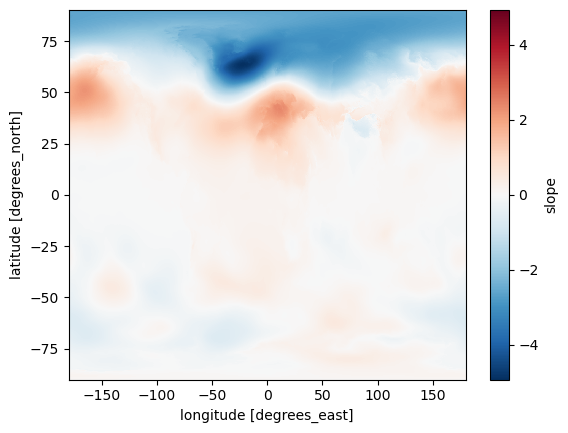

In [56]:
slop1msl.plot()

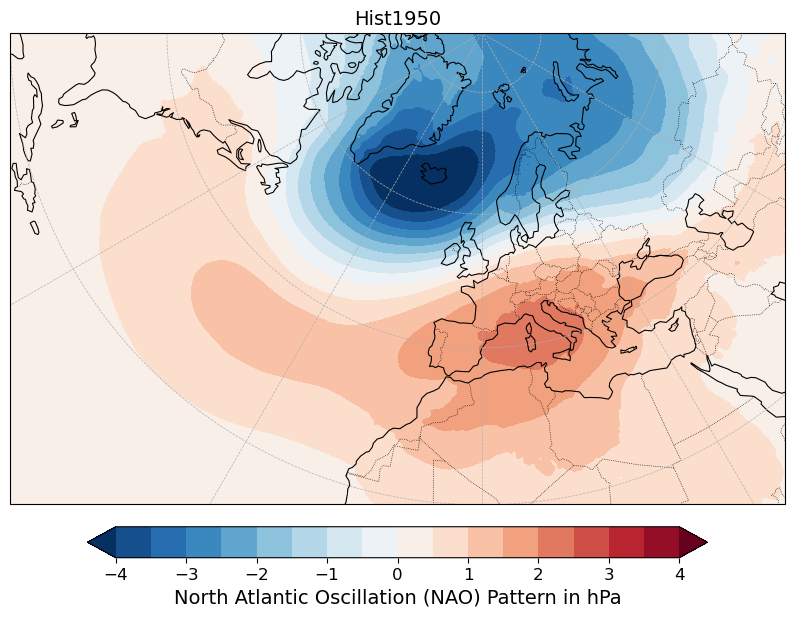

In [71]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Assuming slop1msl is the xarray DataArray with latitude and longitude coordinates

# Plotting
plt.figure(figsize=(10, 10))

# Set up a polar stereographic projection with a central longitude over the North Atlantic
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-30))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Add map features
ax.set_extent([-90, 40, 20, 90], crs=ccrs.PlateCarree())  # Focus on the North Atlantic
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgrey', zorder=0)
ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5)

# Define colorbar limits
vmin = -4.0  # Minimum value
vmax = 4.0   # Maximum value

# Plot the NAO spatial pattern using .plot.contourf()
c = slop1msl.plot.contourf(
    x="lon", y="lat", 
    transform=ccrs.PlateCarree(),
    levels=17, cmap='RdBu_r',
    extend='both', add_colorbar=False,vmin=vmin, vmax=vmax
)

# Add a colorbar
cb = plt.colorbar(c, orientation='horizontal', pad=0.03, shrink=0.8)
cb.set_label("North Atlantic Oscillation (NAO) Pattern in hPa", fontsize=14)
cb.ax.tick_params(labelsize=12)

# Add a title
plt.title("Hist1950", fontsize=14)

# Save the plot
plt.savefig("Reg_NAO_SLP_DJF_Hist1950.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [73]:

tp = ds['tprate'].sel(time=slice('1950', '2008')) * 86400000
tp

<xarray.DataArray 'tprate' (time: 708, lat: 721, lon: 1440)>
dask.array<mul, shape=(708, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2008-12-15T12:00:00

In [74]:

# Step 1: Shift the time coordinate backward by one month
shifted_time = tp['time'].to_index() + pd.DateOffset(months=1)
tp_shifted = tp.assign_coords(time=shifted_time)

# Step 2: Select data for DJF (December, January, February)
tp_djf = tp_shifted.sel(time=tp_shifted['time'].dt.month.isin([1, 2, 3]))
tp_djf

# Step 3: Exclude the first incomplete year (missing December)
first_year = tp_djf['time'].dt.year.min().item() + 1
tp_djf = tp_djf.sel(time=tp_djf['time'].dt.year >= first_year)
tp_djf

# Exclude the last incomplete January (lacks Feb and March)
last_year = tp_djf['time'].dt.year.max().item()
tp_djf = tp_djf.sel(time=~((tp_djf['time'].dt.year == last_year) & (tp_djf['time'].dt.month == 1)))
tp_djf


# Step 5: Resample and calculate the DJF average for each year
tp_djf_avg = tp_djf.resample(time='Y').mean('time')
tp_djf_avg

<xarray.DataArray 'tprate' (time: 58, lat: 721, lon: 1440)>
dask.array<stack, shape=(58, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1951-12-31 1952-12-31 ... 2008-12-31

In [75]:

reg_nao_tp = xr_regression(nao_index , tp_djf_avg, lag_x=0, lag_y=0, dim="time", alternative="two-sided")
reg_nao_tp

slop2msl= reg_nao_tp.slope
pval2msl= reg_nao_tp.pvalue
lat=reg_nao_tp.lat
lon=reg_nao_tp.lon
#pr_cor.plot()
pval2msl = (1 - pval2msl)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


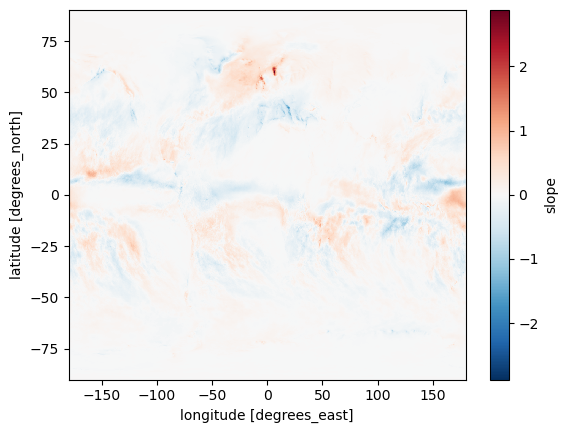

In [76]:
slop2msl.plot()

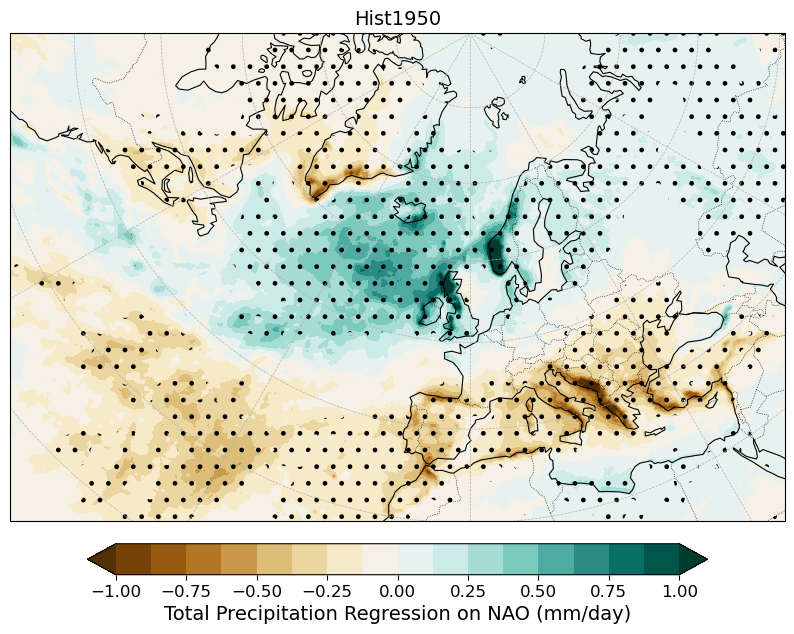

In [81]:


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Assuming slop1msl is the xarray DataArray with latitude and longitude coordinates

# Plotting
plt.figure(figsize=(10, 10))

# Set up a polar stereographic projection with a central longitude over the North Atlantic
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-30))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Add map features
ax.set_extent([-70, 40, 30, 90], crs=ccrs.PlateCarree())  # Focus on the North Atlantic
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgrey', zorder=0)
ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5)

# Define colorbar limits
vmin = -1.0  # Minimum value
vmax = 1.0   # Maximum value

# Plot the NAO spatial pattern using .plot.contourf()
c = slop2msl.plot.contourf(
    x="lon", y="lat", 
    transform=ccrs.PlateCarree(),
    levels=17, cmap='BrBG',
    extend='both', add_colorbar=False,vmin=vmin, vmax=vmax
)

# Overlay pval2msl with hatching
hatch = pval2msl.plot.contourf(
    x="lon", y="lat", 
    transform=ccrs.PlateCarree(),
    colors='none',  # No fill
    levels=[0, 0.95, 1],  # Use the same levels for matching contour levels
    hatches=['', '.'],  # Hatch pattern
    alpha=0,
    add_colorbar=False
)


# Add a colorbar
cb = plt.colorbar(c, orientation='horizontal', pad=0.03, shrink=0.8)
cb.set_label("Total Precipitation Regression on NAO (mm/day)", fontsize=14)
cb.ax.tick_params(labelsize=12)

# Add a title
plt.title("Hist1950", fontsize=14)

# Save the plot
plt.savefig("Reg_NAO_Tot_Precip_DJF_Hist1950.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
